In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [2]:
img = cv2.imread('original.jpg', cv2.IMREAD_GRAYSCALE)

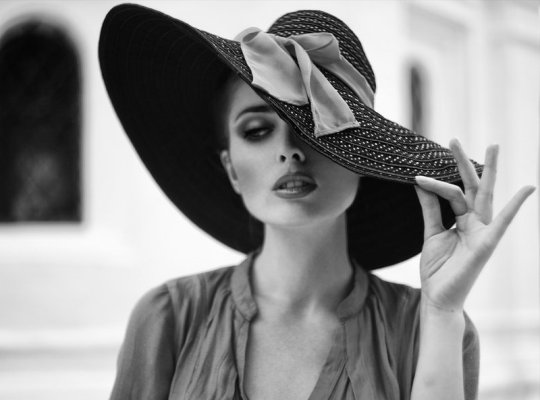

In [3]:
cv2_imshow(img)

In [4]:
mat = np.matrix(img)
with open('input.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%d')

In [5]:
img.shape

(400, 540)

In [15]:
%%writefile task.cu

#include <iostream>
#include <fstream>
#include <stdio.h>
using namespace std;

int* read(int rows, int cols) {
    int* matr = new int[rows*cols];

    ifstream myfile;
    myfile.open ("input.txt");

    for (int i = 0; i < rows*cols; ++i) {
        myfile >> matr[i];
    }
    return matr;
}

void write(int* arr, int n) {
    ofstream file;
    file.open("output.txt");
    for (int i = 0; i < n; ++i)
    {
              file<<arr[i]<< ' ';
    }
	file.close();
}

//CUDA Kernels



__global__ 
void filter(int* img, int rows, int cols, int* res) {
    
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    //printf("Hello world\n");
    if (x<rows && y<cols) {
      atomicAdd(res+img[x*cols+y], 1);
    }
    
}


int main() {
    int rows = 400;
    int cols = 540;
    int* host_img = read(rows, cols);
    int* device_img;
    int* h_res;
    int* d_res;
    cudaMalloc((void**)&device_img, rows*cols*sizeof(int));
    cudaMemcpy(device_img, host_img, rows*cols*sizeof(int), cudaMemcpyHostToDevice);

    cudaMalloc((void**)&d_res, 256*sizeof(int));

    h_res = new int[256]{0};

    filter<<<dim3(16,16), dim3(25, 34)>>>(device_img, rows, cols, d_res);


    cudaMemcpy(h_res, d_res, 256*sizeof(int), cudaMemcpyDeviceToHost);

    write(h_res, 256);


    cudaFree(d_res);
    cudaFree(device_img);
    delete h_res;
    delete[] host_img;
    return 0;
}

Overwriting task.cu


In [16]:
!nvcc -arch sm_35 task.cu

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [17]:
!./a.out

In [18]:
with open('output.txt', 'r') as f:
  for line in f:
    l = [int(num) for num in line.split(' ')[:-1]]
    break

In [19]:
import matplotlib.pyplot as plt

In [22]:
l[0]

41

(array([37348., 14196., 13648., 14772., 15219., 13161., 14683., 15716.,
        27559., 49698.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

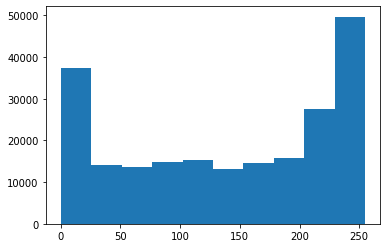

In [20]:
x = [i for i in range(len(l))]
plt.hist(x, weights=l)